# import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Import CSV files

In [2]:
df1 = pd.read_csv("DataSet1.csv")
df2 = pd.read_csv("DataSet2.csv")
df3 = pd.read_csv("DataSet3.csv")

# Handle Values

In [3]:
#Drop missing values
df2.dropna(inplace=True)
df2.reset_index(drop=True, inplace=True)
print(df2.isnull().sum())

#Add BMI column for dataset3
df3["Height (m)"] = df3["Height (cm)"] / 100
df3["BMI"] = df3["Weight (kg)"] / (df3["Height (m)"] ** 2)
df3["BMI"] = df3["BMI"].round(2)

# Drop unneccessary columns to reduce redundancy
df3 = df3[df3["Gender"] != "Other"]
df1 = df1.drop(columns=["Weight (kg)","Height (m)","Workout_Type"])
df2 = df2.drop(columns=["Weight (kg)","Height (m)","Workout_Type"])
df3 = df3.drop(columns=["User ID","Workout Type","Mood Before Workout","Mood After Workout","VO2 Max","Height (m)",
                        "Workout Intensity","Weight (kg)","Height (cm)","Water Intake (liters)","Body Fat (%)"])
df3.reset_index(drop=True, inplace=True)

# Encode Gender
df1['Gender'] = df1['Gender'].map({'Male': 0, 'Female': 1})
df2['Gender'] = df2['Gender'].map({'Male': 0, 'Female': 1})
df3['Gender'] = df3['Gender'].map({'Male': 0, 'Female': 1})

#Turn unncesary float number to integer Ex: age, frequency, level
df2["Age"] = df2["Age"].round(0).astype(int)
df2["Workout_Frequency (days/week)"] = df2["Workout_Frequency (days/week)"].round(0).astype(int)
df2["Experience_Level"] = df2["Experience_Level"].round(0).astype(int)
df2["Calories_Burnedl"] = df2["Calories_Burned"].round(0).astype(int)





Age                              0
Gender                           0
Weight (kg)                      0
Height (m)                       0
Max_BPM                          0
Avg_BPM                          0
Resting_BPM                      0
Session_Duration (hours)         0
Calories_Burned                  0
Workout_Type                     0
Fat_Percentage                   0
Water_Intake (liters)            0
Workout_Frequency (days/week)    0
Experience_Level                 0
BMI                              0
dtype: int64


# Convert objects to numerical values

In [4]:
df2['Max_BPM'] = pd.to_numeric(df2['Max_BPM'], errors='coerce')
df2['BMI'] = pd.to_numeric(df2['BMI'], errors='coerce')

In [5]:
# Fill NaNs with column mean (you could also use median or other strategy)
df1 = df1.fillna(df1.mean(numeric_only=True))
df2 = df2.fillna(df2.mean(numeric_only=True))
df3 = df3.fillna(df3.mean(numeric_only=True))


# CNN Model

In [ ]:
# CNN-based Regression Model for the Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# CNN Model
class CNN1D(nn.Module):
    def __init__(self, input_size):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.AdaptiveMaxPool1d(1)

        self.fc1 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.out = nn.Linear(32, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, 1, features)
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu3(self.fc1(x))
        return self.out(x)





## Split Data

In [7]:
X1, y1 = df1.drop(columns="Calories_Burned"), df1["Calories_Burned"]
X2, y2 = df2.drop(columns="Calories_Burned"), df2["Calories_Burned"]
X3, y3 = df3.drop(columns="Calories Burned"), df3["Calories Burned"]

def split_dataset(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)
X_train_1, X_test_1, y_train_1, y_test_1 = split_dataset(X1, y1)
X_train_2, X_test_2, y_train_2, y_test_2 = split_dataset(X2, y2)
X_train_3, X_test_3, y_train_3, y_test_3 = split_dataset(X3, y3)


## Training function

In [ ]:
def train_cnn(X_train, y_train, X_test):

    # Normalize inputs
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert to tensors (no need to unsqueeze here, model does it)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

    # Dataset and loader
    train_dataset = TensorDataset(X_train, y_train)
    loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Initialize your external CNN model
    model = CNN1D(X_train.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    train_losses = []

    for epoch in range(50):
        model.train()
        epoch_loss = 0
        for xb, yb in loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    # Predict on test set
    model.eval()
    with torch.no_grad():
        preds = model(X_test).numpy()

    return preds, train_losses


In [16]:
y_pred_1, losses_1 = train_cnn(X_train_1, y_train_1, X_test_1)
y_pred_2, losses_2 = train_cnn(X_train_2, y_train_2, X_test_2)
y_pred_3, losses_3 = train_cnn(X_train_3, y_train_3, X_test_3)

Epoch 1, Loss: 887437.1050
Epoch 2, Loss: 873799.8075
Epoch 3, Loss: 812529.7500
Epoch 4, Loss: 652149.6412
Epoch 5, Loss: 380000.9456
Epoch 6, Loss: 130047.2934
Epoch 7, Loss: 78111.7444
Epoch 8, Loss: 71835.2202
Epoch 9, Loss: 68713.6133
Epoch 10, Loss: 66333.7703
Epoch 11, Loss: 61450.8309
Epoch 12, Loss: 59536.4889
Epoch 13, Loss: 58478.9745
Epoch 14, Loss: 55168.1019
Epoch 15, Loss: 54406.4769
Epoch 16, Loss: 53478.2629
Epoch 17, Loss: 50686.5905
Epoch 18, Loss: 49518.8423
Epoch 19, Loss: 47697.2941
Epoch 20, Loss: 46143.1159
Epoch 21, Loss: 45870.9230
Epoch 22, Loss: 44794.8189
Epoch 23, Loss: 42856.4223
Epoch 24, Loss: 42188.4405
Epoch 25, Loss: 40717.7773
Epoch 26, Loss: 39374.4940
Epoch 27, Loss: 39250.0618
Epoch 28, Loss: 36977.0298
Epoch 29, Loss: 36916.5436
Epoch 30, Loss: 35099.0570
Epoch 31, Loss: 34104.8359
Epoch 32, Loss: 33733.8091
Epoch 33, Loss: 32664.0784
Epoch 34, Loss: 31099.3165
Epoch 35, Loss: 30190.2991
Epoch 36, Loss: 30136.1329
Epoch 37, Loss: 28679.4123
Epoc

In [17]:
mae_1 = mean_absolute_error(y_test_1, y_pred_1)
mae_2 = mean_absolute_error(y_test_2, y_pred_2)
mae_3 = mean_absolute_error(y_test_3, y_pred_3)

mse_1 = mean_squared_error(y_test_1, y_pred_1)
mse_2 = mean_squared_error(y_test_2, y_pred_2)
mse_3 = mean_squared_error(y_test_3, y_pred_3)

r2_1 = r2_score(y_test_1, y_pred_1)
r2_2 = r2_score(y_test_2, y_pred_2)
r2_3 = r2_score(y_test_3, y_pred_3)

print(f"Dataset1: mae_score: {mae_1} mse_score: {mse_1} r2_score: {r2_1}")
print(f"Dataset2: mae_score: {mae_2} mse_score: {mse_2} r2_score: {r2_2}")
print(f"Dataset3: mae_score: {mae_3} mse_score: {mse_3} r2_score: {r2_3}")

Dataset1: mae_score: 111.79526977539062 mse_score: 19031.358781742758 r2_score: 0.7718747026385837
Dataset2: mae_score: 252.1837636162253 mse_score: 95471.07988651923 r2_score: 0.0701004436468482
Dataset3: mae_score: 223.63595063964104 mse_score: 66790.4718530141 r2_score: -0.008011817932128906


## Data Visualization

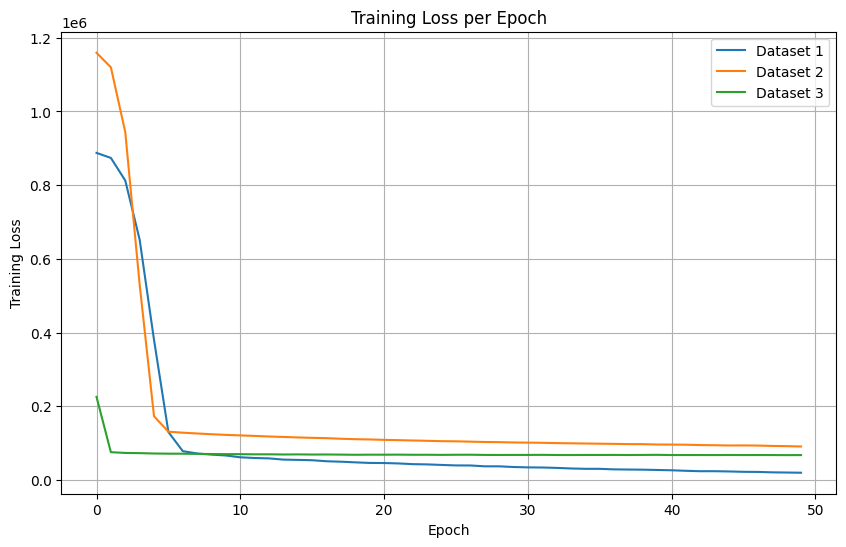

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(losses_1, label="Dataset 1")
plt.plot(losses_2, label="Dataset 2")
plt.plot(losses_3, label="Dataset 3")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

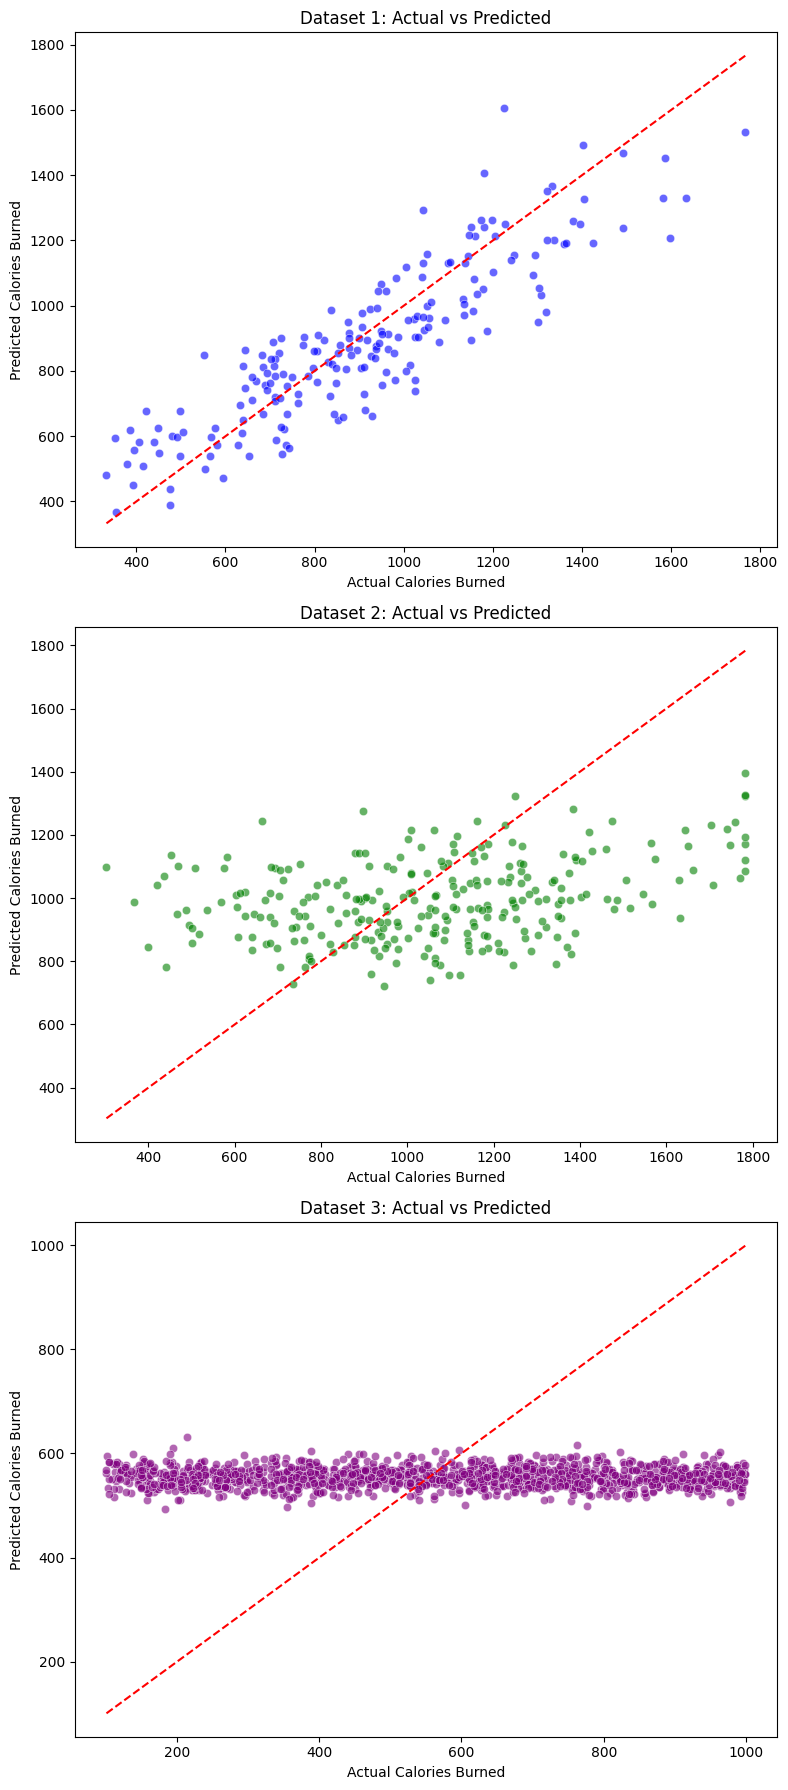

In [19]:

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 18))

# Scatter plot for Dataset 1
sns.scatterplot(x=y_test_1, y=y_pred_1.flatten(), ax=axes[0], color="blue", alpha=0.6)
axes[0].plot([min(y_test_1), max(y_test_1)], [min(y_test_1), max(y_test_1)], color='red', linestyle='--')
axes[0].set_title("Dataset 1: Actual vs Predicted")
axes[0].set_xlabel("Actual Calories Burned")
axes[0].set_ylabel("Predicted Calories Burned")

# Scatter plot for Dataset 2
sns.scatterplot(x=y_test_2, y=y_pred_2.flatten(), ax=axes[1], color="green", alpha=0.6)
axes[1].plot([min(y_test_2), max(y_test_2)], [min(y_test_2), max(y_test_2)], color='red', linestyle='--')
axes[1].set_title("Dataset 2: Actual vs Predicted")
axes[1].set_xlabel("Actual Calories Burned")
axes[1].set_ylabel("Predicted Calories Burned")

# Scatter plot for Dataset 3
sns.scatterplot(x=y_test_3, y=y_pred_3.flatten(), ax=axes[2], color="purple", alpha=0.6)
axes[2].plot([min(y_test_3), max(y_test_3)], [min(y_test_3), max(y_test_3)], color='red', linestyle='--')
axes[2].set_title("Dataset 3: Actual vs Predicted")
axes[2].set_xlabel("Actual Calories Burned")
axes[2].set_ylabel("Predicted Calories Burned")

plt.tight_layout()
plt.show()